In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import src.geometry as geometry

data_dir = '/home/ming/repos/VPR_PF/data/processed/RobotCar'

def combine_lists(lists):
    """
    For list of list of poses (as in VO and RTK relative pose data),
    concatenate into a single pose object and return.
    """
    master = []
    for li in lists:
        master.append(geometry.combine(li))
    return geometry.combine(master)

def covar_to_correl(covar):
    v = np.sqrt(np.diag(covar))
    outer_v = np.outer(v, v)
    correlation = covar / outer_v
    correlation[covar == 0] = 0.
    return correlation

def correl_to_covar(correl, std):
    v = np.outer(std, std)
    covar = correl * v
    return covar

In [2]:
3.1415 / 180 * 3

0.05235833333333334

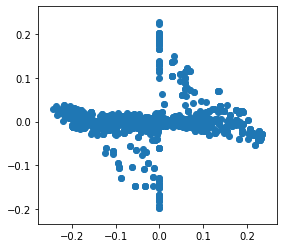

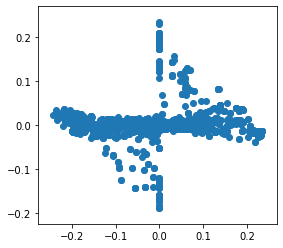

Coefficients
 [[ 1.474e+00 -4.300e-02  7.000e-03  1.000e-03  2.000e-03  8.000e-03]
 [-4.730e-01 -9.000e-03 -9.000e-03 -0.000e+00 -2.000e-03 -4.000e-03]
 [ 3.160e-01 -1.063e+00  5.400e-02 -1.000e-03  3.000e-03  1.700e-02]
 [ 4.840e-01  6.800e-02 -1.050e+00  5.000e-03 -2.300e-02 -2.800e-02]
 [-4.310e+00  5.340e-01 -4.000e-02 -1.898e+00 -4.100e-02  8.700e-02]
 [-2.810e-01  1.000e-02  1.291e+00  2.000e-03 -7.300e-02 -1.500e-02]
 [ 3.500e-01 -1.300e-01 -4.400e-02  4.400e-02  4.100e-02  9.000e-03]]
Correlation, linear model
 [[ 1.    -0.223 -0.011 -0.054  0.009 -0.084]
 [-0.223  1.    -0.162 -0.059 -0.034 -0.085]
 [-0.011 -0.162  1.     0.048  0.295 -0.003]
 [-0.054 -0.059  0.048  1.    -0.001 -0.025]
 [ 0.009 -0.034  0.295 -0.001  1.     0.174]
 [-0.084 -0.085 -0.003 -0.025  0.174  1.   ]]
Correlation, zero mean
 [[ 1.     0.077 -0.311 -0.001 -0.018  0.016]
 [ 0.077  1.    -0.519  0.158 -0.42  -0.108]
 [-0.311 -0.519  1.     0.041  0.315  0.012]
 [-0.001  0.158  0.041  1.    -0.024 -0.057]


In [17]:
dusk_dir = data_dir + '/2014-11-21-16-07-03/query/'

with open(dusk_dir + 'traverses.pickle', 'rb') as f:
    data = pickle.load(f)
    
gt_raw = data['gt_motion'] # RTK relative pose
vo_raw = data['vo'] # VO relative pose

# single pose element for RTK and VO relative poses
gt = combine_lists(gt_raw)
vo = combine_lists(vo_raw)

err = geometry.logSE3(gt * vo.inv())
vo_se3 = geometry.logSE3(vo)

# fit regression coefficients
X = np.concatenate((np.ones(shape=(len(vo_se3), 1)), vo_se3), axis=1)
A = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ err 

pred_err = X @ A
resid = err - pred_err

ind = 5 # for visualizing residuals
plt.scatter(vo_se3[:, ind], resid[:, ind])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

plt.scatter(vo_se3[:, ind], err[:, ind])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print("Coefficients\n", np.around(A, 3))

# fit error covariance
H = X @ np.linalg.inv(X.transpose() @ X) @ X.transpose()
Sigma = err.transpose() @ (np.eye(len(vo_se3)) - H) @ err / len(vo_se3)
Sigma0 = err.transpose() @ err / len(vo_se3) # covariance with no linear model

rho = covar_to_correl(Sigma)
rho0 = covar_to_correl(Sigma0)

print("Correlation, linear model\n", np.around(rho, 3))
print("Correlation, zero mean\n", np.around(rho0, 3))

print("Noise, linear model\n", np.around(np.sqrt(np.diag(Sigma)), 5))
print("Noise, zero mean\n", np.around(np.sqrt(np.diag(Sigma0)), 5))

In [12]:
np.array([[ 1.616e+00, -4.900e-02,  9.000e-03,  1.000e-03,  1.000e-03,  1.000e-03],
                                     [-5.450e-01, -4.000e-03, -1.000e-02, -0.000e+00, -2.000e-03, -1.000e-03],
                                     [ 2.150e-01, -1.064e+00,  6.100e-02,  0.000e+00, -0.000e+00,  9.000e-03],
                                     [-7.000e-02,  1.050e-01, -1.061e+00,  6.000e-03, -3.500e-02, -1.300e-02],
                                     [-6.661e+00,  4.840e-01, -1.350e-01, -1.936e+00, -1.070e-01,  1.090e-01],
                                     [-7.510e-01,  2.000e-02,  1.180e+00,  2.200e-02, -1.410e-01, -3.700e-02],
                                     [-5.710e-01, -4.600e-02, -5.300e-02,  3.700e-02,  4.200e-02,  1.900e-02]])

array([[ 1.616e+00, -4.900e-02,  9.000e-03,  1.000e-03,  1.000e-03,
         1.000e-03],
       [-5.450e-01, -4.000e-03, -1.000e-02, -0.000e+00, -2.000e-03,
        -1.000e-03],
       [ 2.150e-01, -1.064e+00,  6.100e-02,  0.000e+00, -0.000e+00,
         9.000e-03],
       [-7.000e-02,  1.050e-01, -1.061e+00,  6.000e-03, -3.500e-02,
        -1.300e-02],
       [-6.661e+00,  4.840e-01, -1.350e-01, -1.936e+00, -1.070e-01,
         1.090e-01],
       [-7.510e-01,  2.000e-02,  1.180e+00,  2.200e-02, -1.410e-01,
        -3.700e-02],
       [-5.710e-01, -4.600e-02, -5.300e-02,  3.700e-02,  4.200e-02,
         1.900e-02]])

In [4]:
0.02 * 180 / 3.1415

1.145949387235397

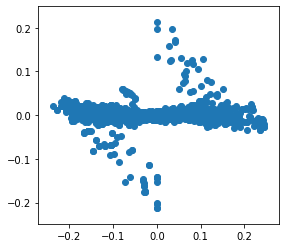

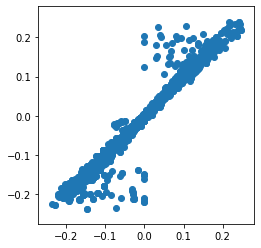

Coefficients
 [[ 9.230e-01 -5.500e-02 -1.600e-02  1.000e-03  1.000e-03 -9.000e-03]
 [-4.580e-01 -9.000e-03 -5.000e-03  1.000e-03 -4.000e-03  4.000e-03]
 [-1.300e-02 -1.080e+00 -2.400e-02  1.000e-03 -5.000e-03  2.400e-02]
 [-2.159e+00 -1.680e-01 -1.061e+00  1.400e-02 -6.400e-02  3.000e-02]
 [-8.860e-01 -9.900e-02 -2.100e-01 -1.924e+00  8.000e-03  9.200e-02]
 [ 2.060e-01  3.520e-01  1.240e+00  2.300e-02 -9.600e-02  1.700e-02]
 [ 4.000e-01 -6.000e-02  6.100e-02  5.700e-02  4.900e-02 -2.100e-02]]
Correlation, linear model
 [[ 1.    -0.077 -0.115 -0.016 -0.035 -0.023]
 [-0.077  1.     0.261 -0.042 -0.023  0.009]
 [-0.115  0.261  1.    -0.014  0.247 -0.006]
 [-0.016 -0.042 -0.014  1.    -0.004  0.098]
 [-0.035 -0.023  0.247 -0.004  1.     0.042]
 [-0.023  0.009 -0.006  0.098  0.042  1.   ]]
Correlation, zero mean
 [[ 1.     0.041 -0.506  0.009 -0.066 -0.087]
 [ 0.041  1.    -0.125  0.155 -0.257 -0.058]
 [-0.506 -0.125  1.     0.012  0.156 -0.004]
 [ 0.009  0.155  0.012  1.    -0.082 -0.053]


In [22]:
night_dir = data_dir + '/2014-12-16-18-44-24/query/'

with open(night_dir + 'traverses.pickle', 'rb') as f:
    data = pickle.load(f)
    
gt_raw = data['gt_motion'] # RTK relative pose
vo_raw = data['vo'] # VO relative pose

# single pose element for RTK and VO relative poses
gt = combine_lists(gt_raw)
vo = combine_lists(vo_raw)

err = geometry.logSE3(gt * vo.inv())
vo_se3 = geometry.logSE3(vo)

# fit regression coefficients
X = np.concatenate((np.ones(shape=(len(vo_se3), 1)), vo_se3), axis=1)
A = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ err 

pred_err = X @ A
resid = err - pred_err

ind = 5 # for visualizing residuals
plt.scatter(vo_se3[:, ind], resid[:, ind])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

plt.scatter(vo_se3[:, ind], geometry.logSE3(gt)[:, ind])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print("Coefficients\n", np.around(A, 3))

# fit error covariance
H = X @ np.linalg.inv(X.transpose() @ X) @ X.transpose()
Sigma = err.transpose() @ (np.eye(len(vo_se3)) - H) @ err / len(vo_se3)
Sigma0 = err.transpose() @ err / len(vo_se3) # covariance with no linear model

rho = covar_to_correl(Sigma)
rho0 = covar_to_correl(Sigma0)

print("Correlation, linear model\n", np.around(rho, 3))
print("Correlation, zero mean\n", np.around(rho0, 3))

print("Noise, linear model\n", np.around(Sigma, 5))
print("Noise, zero mean\n", np.around(np.sqrt(np.diag(Sigma0)), 5))

In [20]:
0.2 * 180 / 3.1415

11.45949387235397

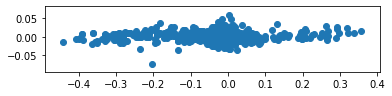

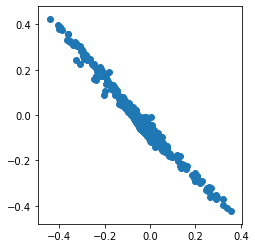

Coefficients
 [[ 5.790e-01 -2.400e-02 -2.000e-03  0.000e+00  4.000e-03 -2.000e-03]
 [-2.980e-01 -1.700e-02 -1.000e-02  2.000e-03 -5.000e-03  5.000e-03]
 [ 5.990e-01 -9.920e-01  1.500e-02 -8.000e-03 -2.100e-02  8.900e-02]
 [-1.638e+00 -1.000e-03 -9.400e-01  3.200e-02 -7.500e-02  6.900e-02]
 [-2.740e-01  1.680e-01 -1.390e-01 -1.852e+00  1.800e-02 -5.000e-03]
 [ 3.780e-01  9.800e-02  1.296e+00  2.500e-02 -1.220e-01  2.400e-02]
 [-4.020e-01 -1.760e-01  3.200e-02  6.100e-02  8.800e-02 -1.640e-01]]
Correlation, linear model
 [[ 1.    -0.359 -0.221 -0.016 -0.036 -0.034]
 [-0.359  1.    -0.114 -0.18   0.02  -0.147]
 [-0.221 -0.114  1.     0.047  0.691 -0.028]
 [-0.016 -0.18   0.047  1.     0.012  0.073]
 [-0.036  0.02   0.691  0.012  1.     0.017]
 [-0.034 -0.147 -0.028  0.073  0.017  1.   ]]
Correlation, zero mean
 [[ 1.     0.168 -0.395 -0.018 -0.042  0.046]
 [ 0.168  1.    -0.509  0.213 -0.478  0.152]
 [-0.395 -0.509  1.    -0.015  0.215 -0.172]
 [-0.018  0.213 -0.015  1.    -0.063 -0.108]


In [6]:
rain_dir = data_dir + '/2015-10-29-12-18-17/query/'

with open(rain_dir + 'traverses.pickle', 'rb') as f:
    data = pickle.load(f)
    
gt_raw = data['gt_motion'] # RTK relative pose
vo_raw = data['vo'] # VO relative pose

# single pose element for RTK and VO relative poses
gt = combine_lists(gt_raw)
vo = combine_lists(vo_raw)

err = geometry.logSE3(gt * vo.inv())
vo_se3 = geometry.logSE3(vo)

# fit regression coefficients
X = np.concatenate((np.ones(shape=(len(vo_se3), 1)), vo_se3), axis=1)
A = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ err 

pred_err = X @ A
resid = err - pred_err

ind = 1 # for visualizing residuals
plt.scatter(vo_se3[:, ind], resid[:, ind])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

plt.scatter(vo_se3[:, ind], err[:, ind])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print("Coefficients\n", np.around(A, 3))

# fit error covariance
H = X @ np.linalg.inv(X.transpose() @ X) @ X.transpose()
Sigma = err.transpose() @ (np.eye(len(vo_se3)) - H) @ err / len(vo_se3)
Sigma0 = err.transpose() @ err / len(vo_se3) # covariance with no linear model

rho = covar_to_correl(Sigma)
rho0 = covar_to_correl(Sigma0)

print("Correlation, linear model\n", np.around(rho, 3))
print("Correlation, zero mean\n", np.around(rho0, 3))

print("Noise, linear model\n", np.around(Sigma, 5))
print("Noise, zero mean\n", np.around(Sigma0, 5))